# MiniTokenNLP – Custom Tokenizer & Embedding Visualization

**Goal:** Build a minimal tokenizer and embedding layer from scratch, visualize the resulting feature space, and interpret patterns in word representations.

## 1. Introduction
This notebook demonstrates how text data can be numerically represented through tokenization and embedding.

Steps:
1. Load and clean movie review texts.
2. Build a simple tokenizer from scratch.
3. Construct random embeddings for each word.
4. Visualize the embedding space.
5. Discuss what these visualizations reveal about language representation.

## 2. Dataset Preparation
We use NLTK's `movie_reviews` dataset which contains 2000 labeled reviews.

In [13]:
import nltk
nltk.data.path.append("./nltk_data")
from nltk.corpus import movie_reviews
import random

# Load dataset
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

print(documents[0])

(['susan', 'granger', "'", 's', 'review', 'of', '"', 'mulholland', 'drive', '"', '(', 'universal', 'focus', ')', 'whatever', 'david', 'lynch', 'is', 'selling', ',', 'i', "'", 'm', 'not', 'buying', '.', 'from', 'the', 'writer', '/', 'director', 'of', '"', 'blue', 'velvet', '"', 'and', '"', 'twin', 'peaks', '"', 'comes', 'another', 'dark', ',', 'mysterious', 'thriller', 'that', 'opens', 'with', 'an', 'automobile', 'accident', 'on', 'mulholland', 'drive', ',', 'the', 'serpentine', 'street', 'that', 'twists', 'high', 'in', 'the', 'hollywood', 'hills', '.', 'dazed', ',', 'a', 'beautiful', 'brunette', '(', 'laura', 'elena', 'harring', ')', 'emerges', 'and', 'stumbles', 'down', 'a', 'hill', ',', 'slipping', 'unobserved', 'into', 'a', "'", '30s', '-', 'style', 'apartment', 'as', 'the', 'tenant', 'leaves', 'for', 'a', 'trip', '.', 'the', 'next', 'morning', ',', 'a', 'dewy', 'blonde', '(', 'naomi', 'watts', ')', 'from', 'deep', 'river', ',', 'ontario', ',', 'arrives', 'in', 'la', 'with', 'dreams

## 3. Text Cleaning
To make the vocabulary more meaningful, we:
- Lowercase all words
- Remove punctuation and stopwords
- Keep alphabetic tokens only

In [14]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(words):
    return [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]

cleaned_texts = [clean_text(words) for words, _ in documents]

print(cleaned_texts[0])

['susan', 'granger', 'review', 'mulholland', 'drive', 'universal', 'focus', 'whatever', 'david', 'lynch', 'selling', 'buying', 'writer', 'director', 'blue', 'velvet', 'twin', 'peaks', 'comes', 'another', 'dark', 'mysterious', 'thriller', 'opens', 'automobile', 'accident', 'mulholland', 'drive', 'serpentine', 'street', 'twists', 'high', 'hollywood', 'hills', 'dazed', 'beautiful', 'brunette', 'laura', 'elena', 'harring', 'emerges', 'stumbles', 'hill', 'slipping', 'unobserved', 'style', 'apartment', 'tenant', 'leaves', 'trip', 'next', 'morning', 'dewy', 'blonde', 'naomi', 'watts', 'deep', 'river', 'ontario', 'arrives', 'la', 'dreams', 'stardom', 'suitcase', 'aunt', 'owns', 'apartment', 'two', 'women', 'meet', 'brunette', 'amnesia', 'blonde', 'tries', 'help', 'discover', 'identity', 'along', 'latent', 'lesbian', 'lust', 'meanwhile', 'hotshot', 'director', 'justin', 'theroux', 'whose', 'wife', 'bed', 'poolman', 'forced', 'cast', 'certain', 'actress', 'new', 'film', 'assassin', 'mark', 'pell

## 4. Custom Tokenizer
We build a simple word-level tokenizer that constructs a vocabulary and assigns each word an integer ID.

In [15]:
from collections import Counter

# Define a simple word-level tokenizer class
class MiniTokenizer:
    def __init__(self, min_freq=3):
        """
        Initialize the tokenizer.
        :arg min_freq(int): minimum frequency a word must have to be included in the vocabulary.
        """
        self.min_freq = min_freq
        # Initialize vocabulary with two special tokens:
        # <PAD> for padding and <UNK> for unknown (out-of-vocabulary) words.
        self.word2id = {"<PAD>": 0, "<UNK>": 1}
        self.id2word = {0: "<PAD>", 1: "<UNK>"}

    def fit(self, texts):
        """
        Build the vocabulary from the training corpus.
        :arg texts: list of tokenized sentences.
        """
        # Count the frequency of each word across all texts
        freq = Counter([w for text in texts for w in text])
        # Add words that meet the frequency threshold to the vocabulary
        for w, c in freq.items():
            if c >= self.min_freq:
                idx = len(self.word2id)
                self.word2id[w] = idx
                self.id2word[idx] = w

    def encode(self, text):
        """
        Convert a list of tokens into a list of integer IDs.
        Unknown words are mapped to <UNK>.
        """
        return [self.word2id.get(w, 1) for w in text]

tokenizer = MiniTokenizer(min_freq=3)
# Build vocabulary from cleaned training texts
tokenizer.fit(cleaned_texts)
# Check the vocabulary size
vocab_size = len(tokenizer.word2id)
print("Vocabulary size:", vocab_size)

Vocabulary size: 19779


## 5. Embedding Construction
We assign each word a random embedding vector of dimension 50.
Though not trained, this embedding allows us to visualize the structure of the vocabulary in a continuous space.

In [16]:
import numpy as np

# Set the dimensionality of the embedding vectors
embedding_dim = 50 # Each word will be represented by a 50-dimensional vector
# Initialize a random embedding matrix
# Shape: (vocab_size, embedding_dim)
# Each row corresponds to one word in the vocabulary,
# and each column represents one "feature" of that word's semantic meaning.
embedding_matrix = np.random.uniform(
    low=-0.01, # Lower bound for random initialization
    high=0.01, # Upper bound
    size=(vocab_size, embedding_dim)
)

## 6. Generate Sentence Embeddings and Export Data

After building the tokenizer and embedding matrix, we now transform each text review into a numerical representation that can be used by other models.

Steps:
1. Encode each cleaned review into token IDs using our custom tokenizer.
2. Pad or truncate each sequence to a fixed length (for consistency).
3. Use the embedding matrix to map token IDs to dense vectors.
4. Average each sentence's word embeddings into a single 50-dimensional vector.
5. Export the resulting embeddings and labels to CSV files, so other notebooks in the group can train models using the same processed data.

In [17]:
# -------------------------------------------------
# Step 6.1: Encode and Pad Token Sequences
# -------------------------------------------------

import numpy as np

def pad_sequence(seq, max_len):
    """
    Pads or truncates a tokenized sentence to a fixed length.
    Shorter sequences are padded with zeros (<PAD> = 0),
    and longer ones are truncated.
    """
    return seq[:max_len] + [0] * (max_len - len(seq))

# Set a reasonable maximum length for each review
max_len = 200

# Convert each cleaned text to a sequence of token IDs
X_encoded = [pad_sequence(tokenizer.encode(text), max_len) for text in cleaned_texts]

print("Example encoded review:", X_encoded[0][:20])
print("Total encoded samples:", len(X_encoded))

Example encoded review: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Total encoded samples: 2000


In [18]:
# -------------------------------------------------
# Step 6.2: Split Encoded Data into Train and Test Sets
# -------------------------------------------------

# 80% training, 20% testing
train_size = int(0.8 * len(X_encoded))

# Convert lists to numpy arrays for easier handling
X_train_seq = np.array(X_encoded[:train_size])
X_test_seq = np.array(X_encoded[train_size:])

# Convert labels ("pos"/"neg") into binary form (1/0)
y_train = np.array([1 if label == 'pos' else 0 for _, label in documents[:train_size]])
y_test = np.array([1 if label == 'pos' else 0 for _, label in documents[train_size:]])

print("Train set shape:", X_train_seq.shape)
print("Test set shape:", X_test_seq.shape)
print("Example label distribution:", np.bincount(y_train))

Train set shape: (1600, 200)
Test set shape: (400, 200)
Example label distribution: [803 797]


## 7. Inspect Vocabulary
Let's look at a few words and their corresponding IDs.


In [19]:
print(list(tokenizer.word2id.items())[:10])

[('<PAD>', 0), ('<UNK>', 1), ('susan', 2), ('granger', 3), ('review', 4), ('mulholland', 5), ('drive', 6), ('universal', 7), ('focus', 8), ('whatever', 9)]


## 8. Visualize Word Embeddings with PCA & t-SNE
We use PCA to project the 50-dimensional embedding vectors into 2D for visualization.

In [20]:
# To avoid overcrowded plots, we randomly pick 300 words from the vocabulary.
subset_size = 300
subset_ids = random.sample(range(2, vocab_size), subset_size)  # skip <PAD> and <UNK>
subset_words = [tokenizer.id2word[i] for i in subset_ids]
subset_vectors = embedding_matrix[subset_ids]

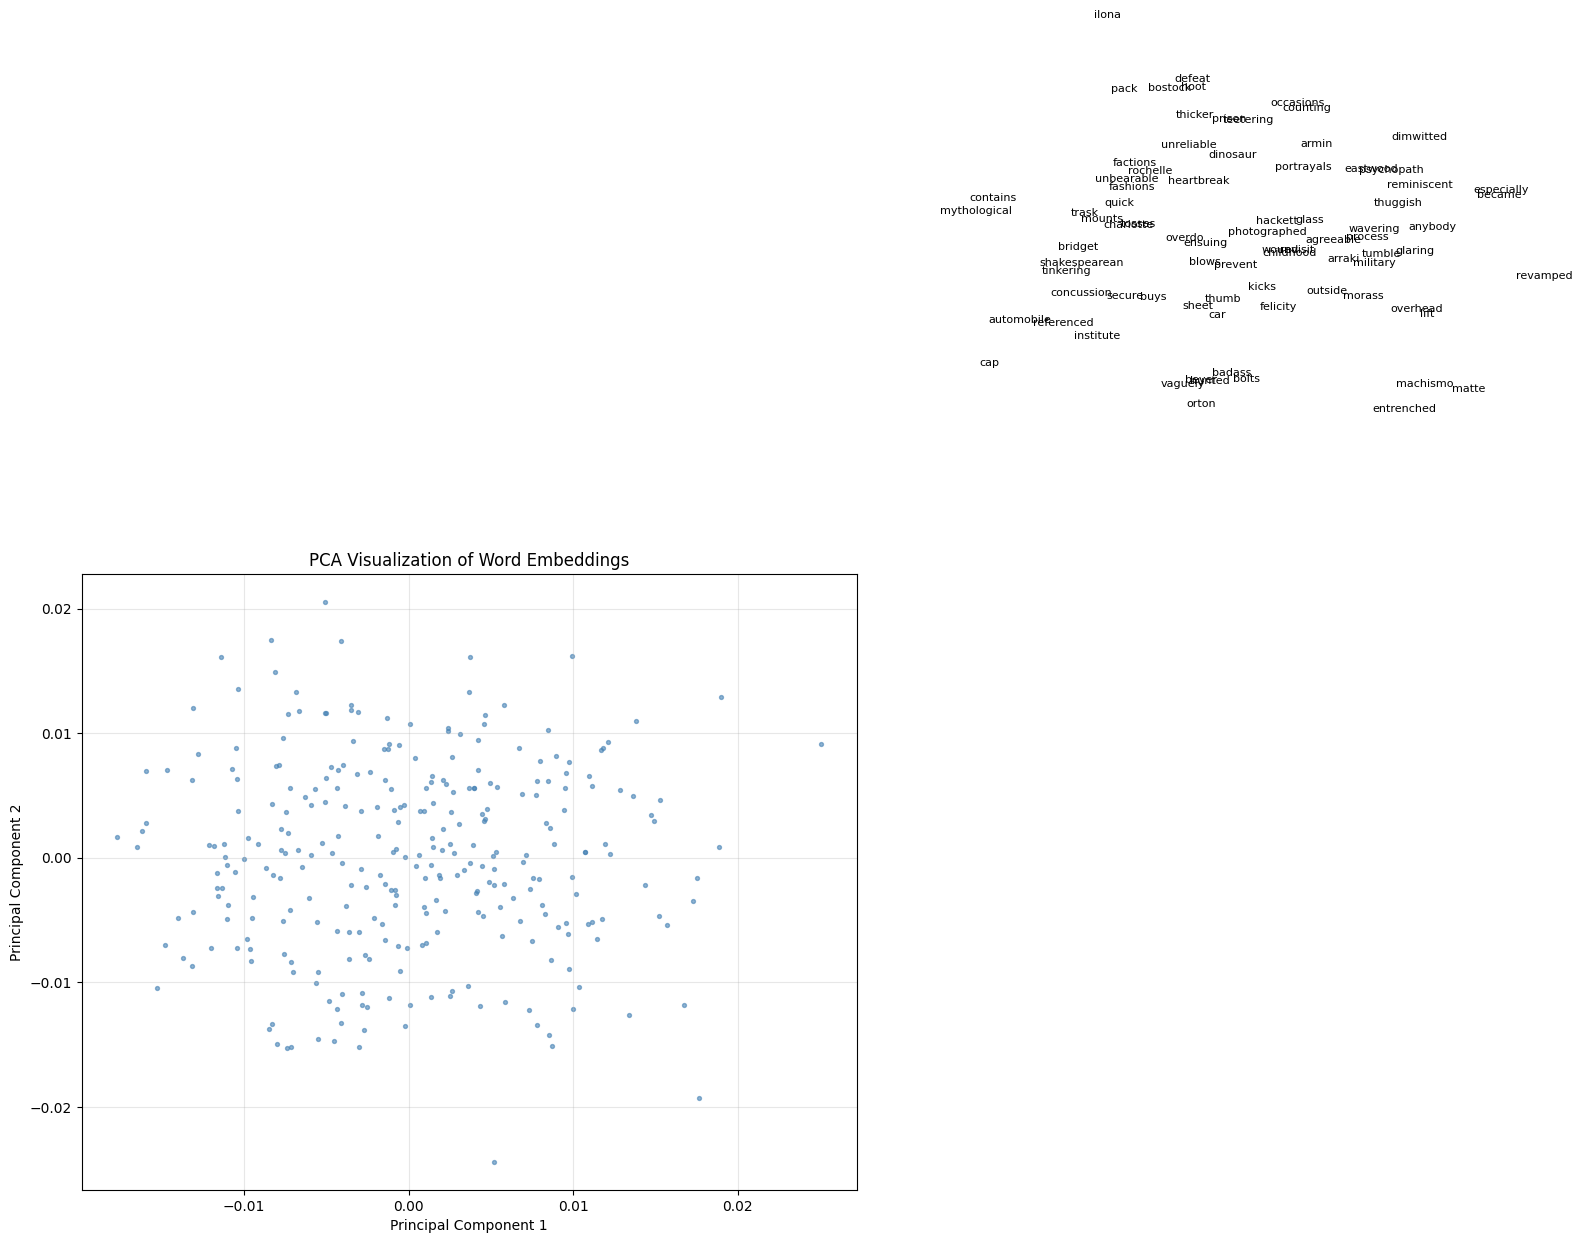

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(subset_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=8, alpha=0.6, color='steelblue')
for i, word in enumerate(subset_words[:80]):  # label only a few to keep it readable
    plt.text(pca_result[i, 0] + 0.05, pca_result[i, 1] + 0.05, word, fontsize=8)
plt.title("PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.show()
plt.show()

t-SNE can better capture local clusters of similar embeddings.
We visualize a random subset of the vocabulary to maintain clarity.

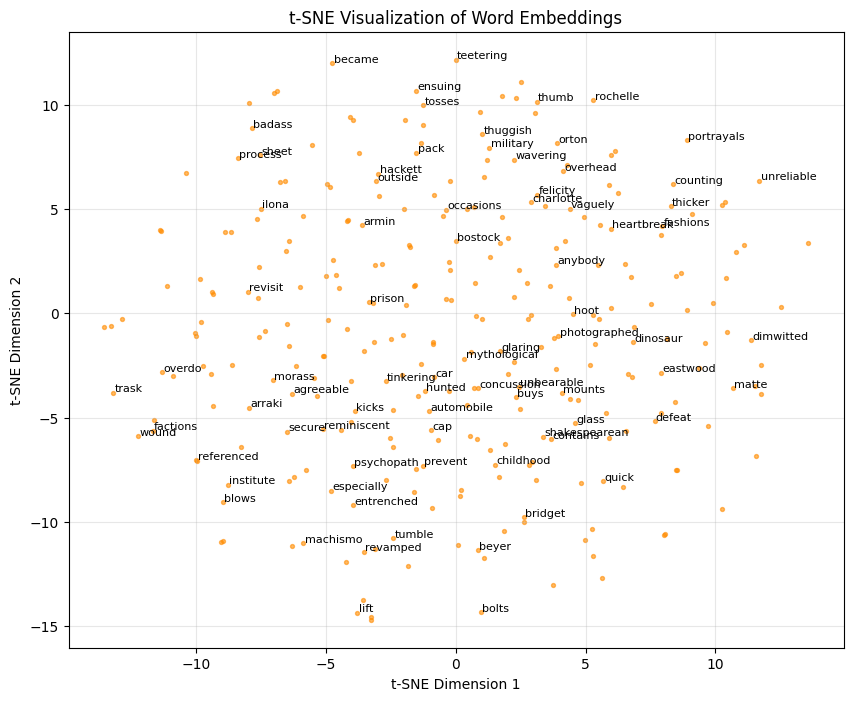

In [22]:
from sklearn.manifold import TSNE

# t-SNE often reveals more local structure (clusters),
# but is slower and non-linear.
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200.0, init='pca', random_state=42)
import numpy as np
subset_vectors = np.asarray(subset_vectors, dtype=np.float64)
tsne_result = tsne.fit_transform(subset_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=8, alpha=0.6, color='darkorange')
for i, word in enumerate(subset_words[:80]):  # label a few words
    plt.text(tsne_result[i, 0] + 0.05, tsne_result[i, 1] + 0.05, word, fontsize=8)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.show()

## 9. Save Embedded Data

In [23]:
import pandas as pd

# Convert numpy arrays into DataFrames
train_df = pd.DataFrame(X_train_seq)
train_df['label'] = y_train  # add target column at the end

test_df = pd.DataFrame(X_test_seq)
test_df['label'] = y_test

# Save as CSV files
train_df.to_csv("dataset/train_embeddings.csv", index=False)
test_df.to_csv("dataset/test_embeddings.csv", index=False)

print("Saved to train_embeddings.csv and test_embeddings.csv")
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

Saved to train_embeddings.csv and test_embeddings.csv
Train shape: (1600, 201) Test shape: (400, 201)


## 10) Export vocabulary for interactive inference
Finally, we exports a minimal vocabulary file so the model notebook can map raw text to token IDs.
Output: `artifacts/tokenizer_word/tokenizer.json`.

In [24]:
# Export tokenizer vocabulary for Model notebook (no third-party libs)
from pathlib import Path
import json

assert 'tokenizer' in globals(), "Tokenizer not found. Make sure you trained it (fit) above."

out_dir = Path("artifacts/tokenizer_word")
out_dir.mkdir(parents=True, exist_ok=True)

# Build id2word list from tokenizer, supporting both list and dict implementations
id2word = getattr(tokenizer, "id2word", None)
id2word_list = None

if isinstance(id2word, list):
    id2word_list = list(id2word)
elif isinstance(id2word, dict):
    id2word_list = [w for i, w in sorted(id2word.items(), key=lambda x: x[0])]
else:
    # fallback: reconstruct from word2id if possible
    w2i = getattr(tokenizer, "word2id", None)
    if isinstance(w2i, dict):
        id_max = max(w2i.values()) if w2i else -1
        id2word_list = [""] * (id_max + 1)
        for w, i in w2i.items():
            id2word_list[i] = w

assert id2word_list and isinstance(id2word_list, list), "Failed to obtain tokenizer vocabulary."

meta = {
    "type": "word",
    "id2word": id2word_list
}
(out_dir / "tokenizer.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2))
print("Saved vocabulary to", out_dir / "tokenizer.json")
print("Vocab size:", len(id2word_list), "First 10:", id2word_list[:10])


Saved vocabulary to artifacts/tokenizer_word/tokenizer.json
Vocab size: 19779 First 10: ['<PAD>', '<UNK>', 'susan', 'granger', 'review', 'mulholland', 'drive', 'universal', 'focus', 'whatever']
